In [1]:
import os
import random
from time import time
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import albumentations as albu

# 재현가능성을 위해 seed 고정

In [2]:
def make_reproducible(seed=0):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
make_reproducible()

# 하이퍼파라미터 담을 `config` 정의

In [4]:
config = {
    'arch': 1,  # 모델 구조 (1,2,3,4 중 하나)
    'aug': True,  # augmentation 유무
    'optimizer': 'momentum',  # optimizer ('momentum', 'adam' 중 하나)
    'lr': 0.1,  # learning rate
    'weight_decay': 1e-4,  # l2 norm
    'batch_size': 1024,  # batch size
    'min_lr': 1e-5,  # learning rate 감소시킬 때 최소값
    'epochs': 300,
#     'rp_patience': 30,  # validation metric이 30 epoch 동안 감소하지 않으면 learning rate 0.3배함
#     'es_patience': 70,  # validation metric이 70 epoch 동안 감소하지 않으면 early stop
    'amp': False,  # mixed precision 유무
    'num_workers': 8,  # dataloader 멀티프로세싱 개수
}

# 데이터 로드 및 Fold 나누기

하이퍼파라미터 튜닝을 위해서는 fold0만 활용하고, 가장 좋은 하이퍼파라미터를 찾으면 5Fold로 학습시켜 평균내 제출한다.

In [5]:
train_data = pd.read_csv('data/train_df.csv')
test_data = pd.read_csv('data/test_df.csv')

x_data = (train_data.drop('label',axis = 1).values.reshape(-1, 28, 28, 1)/255).astype(np.float32)
y_data = train_data['label'].values

x_test = (test_data.drop('Unnamed: 0', axis=1).values.reshape(-1, 28, 28, 1)/255).astype(np.float32)

folds = list(StratifiedKFold(5, shuffle=True, random_state=0).split(x_data, y_data))
trn_idx = folds[0][0]
val_idx = folds[0][1]
x_train, x_val, y_train, y_val = x_data[trn_idx], x_data[val_idx], y_data[trn_idx], y_data[val_idx]

In [6]:
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(33600, 28, 28, 1) (8400, 28, 28, 1) (33600,) (8400,)


# 데이터 로더

In [7]:
class MNISTDataset(nn.Module):
    
    def __init__(self, x, y=None, transforms=None):
        self.x = x
        self.y = y
        self.transforms = transforms
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x = self.x[idx]
        if self.transforms is not None:
            x = self.transforms(image=x)['image']
        x = np.transpose(x, (2, 0, 1))  # h, w, c -> c, h, w
        if self.y is None:
            return x
        else:
            return x, self.y[idx]

In [8]:
if config['aug']:
    train_transforms = albu.Compose([
        albu.RandomBrightnessContrast(brightness_limit=(-0.2, 0.5), contrast_limit=0.5, p=1),
#         albu.OneOf([
#             albu.Blur(blur_limit=2, p=1),
#             albu.GaussianBlur(blur_limit=3, p=1)
#         ], p=0.5),
        albu.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.15, rotate_limit=25, border_mode=0, value=0, p=0.7),
#         albu.CoarseDropout(max_holes=5, max_height=3, max_width=3, p=1)
    ])
else:
    train_transforms = None

In [9]:
train_dataset = MNISTDataset(x_train, y_train, transforms=train_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, config['batch_size'], shuffle=True, num_workers=config['num_workers'])
val_dataset = MNISTDataset(x_val, y_val, transforms=None)
val_loader = torch.utils.data.DataLoader(val_dataset, config['batch_size'], shuffle=False, num_workers=config['num_workers'])
print(f'# Train Samples: {len(train_dataset)} | # Val Samples: {len(val_dataset)}')

# Train Samples: 33600 | # Val Samples: 8400


# 모델

네 종류의 architecture을 고려하였다. arch 4를 제외하고는 파라미터 개수를 비슷하게 맞춰서 동일선상에서 비교하였다.

## arch 1
* residual connection이 있는 기본적인 구조
* https://arxiv.org/abs/1512.03385
* #Parameters: 288170

## arch 2
* mobilenetv2 기반: inverted residual + depthwise seperable
* https://arxiv.org/abs/1801.04381
* #Parameters: 282754

## arch 3
* ecanet 기반: mobilenetv2 + channel-wise attention (eca)
* https://arxiv.org/abs/1910.03151
* #Parameters: 282772

## arch 4
* mobilenetv3 기반: mobilenetv2 + channel-wise attention (squeeze-excitation)
* https://arxiv.org/abs/1905.02244
* #Parameters: 404974

In [10]:
class SimpleBlock(nn.Module):
    
    def __init__(self, in_c, out_c):
        super(SimpleBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, 1, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_c, out_c, 3, 1, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x_ = x
        x = self.conv2(x)
        x = x+x_
        return x

In [11]:
class SELayer(nn.Module):
    
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel//reduction),
            nn.ReLU(),
            nn.Linear(channel//reduction, channel),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y
    
    
class ECALayer(nn.Module):
    
    """Constructs a ECA module.
    Args:
        channel: Number of channels of the input feature map
        k_size: Adaptive selection of kernel size
        
    https://github.com/BangguWu/ECANet/blob/master/models/eca_module.py
    """
    def __init__(self, channel, k_size=3):
        super(ECALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: input features with shape [b, c, h, w]
        b, c, h, w = x.size()

        # feature descriptor on the global spatial information
        y = self.avg_pool(x)

        # Two different branches of ECA module
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)

        # Multi-scale information fusion
        y = self.sigmoid(y)

        return x * y.expand_as(x)
    
    
class Separable(nn.Module):
    
    def __init__(self, in_c, out_c, se=False):
        super(Separable, self).__init__()
        
        hidden_c = in_c*2
        self.expand = nn.Sequential(
            nn.Conv2d(in_c, hidden_c, 1, 1, 0, bias=False),
            nn.BatchNorm2d(hidden_c),
            nn.ReLU()
        )
        
        depthwise = [
            nn.Conv2d(hidden_c, hidden_c, 3, 1, 1, groups=hidden_c, bias=False),
            nn.BatchNorm2d(hidden_c)
        ]
        if se == 'eca': 
            depthwise.append(ECALayer(hidden_c))
        elif se == 'se':
            depthwise.append(SELayer(hidden_c))
        depthwise.append(nn.ReLU())
        self.depthwise = nn.Sequential(*depthwise)

        self.pointwise = nn.Sequential(
            nn.Conv2d(hidden_c, out_c, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_c),
        )
        
    def forward(self, x):
        x = self.expand(x)
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x
    
class MobileBlock(nn.Module):
    
    def __init__(self, in_c, out_c, se=False):
        super(MobileBlock, self).__init__()
        self.conv1 = Separable(in_c, out_c, se=se)
        self.conv2 = Separable(out_c, out_c, se=se)
        
    def forward(self, x):
        x = self.conv1(x)
        x_ = x
        x = self.conv2(x)
        x = x+x_
        return x
    

class Net(nn.Module):
    def __init__(self, arch=1):
        super(Net, self).__init__()
        
        if arch == 1:
            self.block1 = SimpleBlock(1, 32)
            self.block2 = SimpleBlock(32, 64)
            self.block3 = SimpleBlock(64, 128)
            self.head = nn.Linear(128, 10)
        elif arch == 2:
            self.block1 = nn.Sequential(
                nn.Conv2d(1, 24, 3, 1, 1, bias=False),
                nn.BatchNorm2d(24),
                nn.ReLU(),
                MobileBlock(24, 48)
            )
            self.block2 = MobileBlock(48, 96)
            self.block3 = MobileBlock(96, 192)
            self.head = nn.Linear(192, 10)
        elif arch == 3:
            self.block1 = nn.Sequential(
                nn.Conv2d(1, 24, 3, 1, 1, bias=False),
                nn.BatchNorm2d(24),
                nn.ReLU(),
                MobileBlock(24, 48, se='eca')
            )
            self.block2 = MobileBlock(48, 96, se='eca')
            self.block3 = MobileBlock(96, 192, se='eca')
            self.head = nn.Linear(192, 10)
        elif arch == 4:
            self.block1 = nn.Sequential(
                nn.Conv2d(1, 24, 3, 1, 1, bias=False),
                nn.BatchNorm2d(24),
                nn.ReLU(),
                MobileBlock(24, 48, se='se')
            )
            self.block2 = MobileBlock(48, 96, se='se')
            self.block3 = MobileBlock(96, 192, se='se')
            self.head = nn.Linear(192, 10)
            
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.block1(x)
        x = self.pool1(x)
        x = self.block2(x)
        x = self.pool2(x)
        x = self.block3(x)
        x = x.mean(dim=(2,3))
        x = self.head(x)
        return x   

In [12]:
model = Net(config['arch']).cuda()
print(f'# Parameters: {sum(p.numel() for p in model.parameters())}')

# Parameters: 288170


# 손실 함수

In [13]:
criterion = nn.CrossEntropyLoss()

# Optimizer

In [14]:
if config['optimizer'] == 'momentum':
    optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'], momentum=0.9)
elif config['optimizer'] == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

# Learning Rate Scheduler

**실험들에서는 ReduceLROnPlateau scheduler을 썼었는데, 다른 프로젝트를 진행하다가 OneCycleLR이 더 빠른 속도로 수렴한다는 사실을 발견하고 최종 제출본은 OneCycleLR을 사용하였다.**

OneCycleLR scheduler을 쓰면, 기본 하이퍼파라미터 상태에서는 max_lr의 1/25의 lr에서 시작하여 총 Epoch의 1/4만큼 max_lr까지 lr이 증가하다가 그 이후는 max_lr의 1/10000까지 lr이 감소한다. 증가하거나 감소할 때는 cosine함수의 모양을 따른다.

https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.OneCycleLR

https://arxiv.org/abs/1708.07120

In [15]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=config['epochs'])

# Train

EPOCH: 0 | LRs: {0.0040000000000000036}
(train) LOSS: 1.8484819 | METRIC: -0.418898
(valid) LOSS: 1.2124634 | METRIC: -0.42
EPOCH: 1 | LRs: {0.00402926000147058}
(train) LOSS: 0.8500535 | METRIC: -0.778690
(valid) LOSS: 0.5654796 | METRIC: -0.841309
EPOCH: 2 | LRs: {0.004117004333062058}
(train) LOSS: 0.4003340 | METRIC: -0.905476
(valid) LOSS: 0.2994545 | METRIC: -0.855833
EPOCH: 3 | LRs: {0.004263126019804789}
(train) LOSS: 0.2107145 | METRIC: -0.951488
(valid) LOSS: 0.1542595 | METRIC: -0.859761
EPOCH: 4 | LRs: {0.004467446915000062}
(train) LOSS: 0.1408125 | METRIC: -0.965922
(valid) LOSS: 0.1230306 | METRIC: -0.982619
EPOCH: 5 | LRs: {0.004729717917410656}
(train) LOSS: 0.1103263 | METRIC: -0.972619
(valid) LOSS: 0.0934586 | METRIC: -0.976190
EPOCH: 6 | LRs: {0.0050496192749567015}
(train) LOSS: 0.0831756 | METRIC: -0.980238
(valid) LOSS: 0.0800536 | METRIC: -0.979166
EPOCH: 7 | LRs: {0.00542676097454689}
(train) LOSS: 0.0708523 | METRIC: -0.982619
(valid) LOSS: 0.0747827 | METRIC

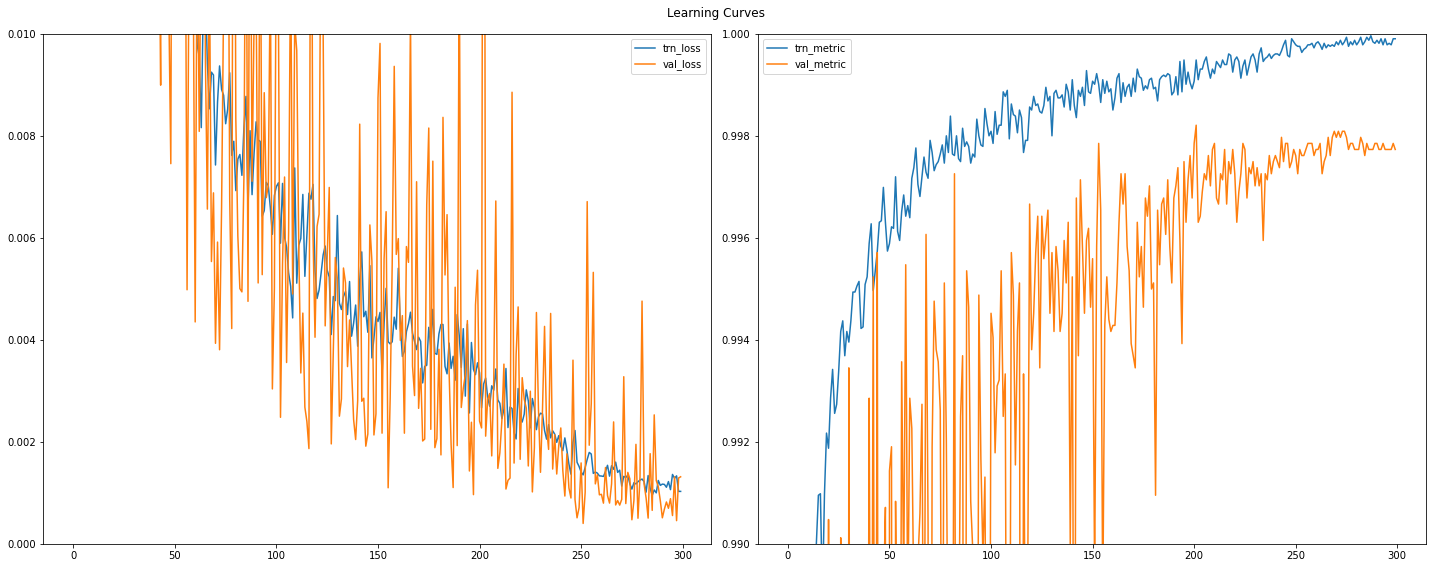

In [16]:
t0 = time()

# mixed precision
scaler = torch.cuda.amp.GradScaler(enabled=config['amp']) 
# validation metric 초기화
best_val_metric = np.inf
# learning curve
learning_curve = pd.DataFrame(columns=['trn_loss', 'trn_metric', 'val_loss', 'val_metric'])

# loop
for epoch in range(config['epochs']):
    
    # 현재 learning rates 출력
    current_lrs = [x["lr"] for x in optimizer.param_groups]
    print(f'EPOCH: {epoch} | LRs: {set(current_lrs)}')
    
    # train
    model.train()
    train_loss = 0.0
    train_metric = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=config['amp']):
            logits = model(inputs) 
            loss = criterion(logits, targets)
        
        # mixed precision
        scaler.scale(loss).backward() 
        scaler.step(optimizer)  
        scaler.update() 
        
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item() * len(inputs) / len(train_dataset)
        train_metric -= (logits.detach().cpu().numpy().argmax(axis=1)==targets.detach().cpu().numpy()).mean() * len(inputs) / len(train_dataset)
            
    str_train_loss = str(train_loss)[:9]
    str_train_metric = str(train_metric)[:9]
    print(f'(train) LOSS: {str_train_loss} | METRIC: {str_train_metric}')

    # validate
    model.eval()
    val_loss = 0.0
    val_metric = 0.0
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            logits = model(inputs) 
            val_preds += logits.cpu().tolist()
            val_targets += targets.cpu().tolist()
            val_loss += loss.item() * len(inputs) / len(val_dataset)
    
    val_preds, val_targets = np.array(val_preds), np.array(val_targets)
    val_metric = -(val_preds.argmax(axis=1)==val_targets).mean() # negative accuracy
    str_val_metric = str(val_metric)[:9]
    str_val_loss = str(val_loss)[:9]
    print(f'(valid) LOSS: {str_val_loss} | METRIC: {str_val_metric}')
    
    # learning curve 업데이트
    learning_curve.loc[epoch] = train_loss, train_metric, val_loss, val_metric

    if val_metric <= best_val_metric:
        # val metric이 개선됐으면 info 저장
        best_info = {
            'epoch': epoch,
            'model': deepcopy(model.state_dict()),
            'amp_scaler': deepcopy(scaler.state_dict()),
            'optimizer': deepcopy(optimizer.state_dict()),
            'scheduler': deepcopy(scheduler.state_dict()),
            'learning_rates': current_lrs,
            'train_loss': train_loss,
            'train_metric': train_metric,
            'val_loss': val_loss,
            'val_metric': val_metric,
            'val_preds': val_preds,
            'config': config
        }
        best_val_metric = val_metric

runtime = int(time()-t0)
print(f'Best Val Score: {best_val_metric}')
print(f'Runtime: {runtime}')

# learning curve 그리기
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
fig.suptitle('Learning Curves')
axes[0].plot(learning_curve['trn_loss'], label='trn_loss')
axes[0].plot(learning_curve['val_loss'], label='val_loss')
axes[0].set_ylim(0.0, 0.01)
axes[0].legend()
axes[1].plot(-learning_curve['trn_metric'], label='trn_metric')
axes[1].plot(-learning_curve['val_metric'], label='val_metric')
axes[1].set_ylim(0.99, 1.0)
axes[1].legend()
plt.tight_layout()
plt.show()

# 실험 결과

| acc     | runtime | arch | optimizer | lr  | weight_decay | batch_size | rp_patience | es_patience | aug           |
|---------|---------|------|-----------|-----|--------------|------------|-------------|-------------|---------------|
| 0.9975  | 136     | 1    | momentum  | 0.1 | 0.0001       | 128        | 8           | 20          | False         |
| 0.99786 | 234     | 1    | momentum  | 0.1 | 0.0001       | 128        | 15          | 35          | False         |
| 0.99810 | 304     | 1    | momentum  | 0.1 | 0.0001       | 128        | 30          | 70          | False         |
| 0.99833 | 437     | 1    | momentum  | 0.1 | 0.0001       | 128        | 30          | 70          | ssr           |
| 0.99833 | 489     | 1    | momentum  | 0.1 | 0.0001       | 128        | 30          | 70          | ssr+bc        |
| 0.99857 | 666     | 1    | momentum  | 0.1 | 0.0001       | 1024       | 30          | 70          | ssr+bc        |
| 0.99774 | 483     | 1    | momentum  | 0.5 | 0.0001       | 1024       | 30          | 70          | ssr+bc        |
| 0.99821 | 697     | 1    | momentum  | 0.1 | 0.0001       | 1024       | 50          | 110         | ssr+bc        |
| 0.99762 | 454     | 1    | momentum  | 0.1 | 0.0001       | 1024       | 30          | 70          | ssr+bc+blur   |
| 0.99762 | 376     | 1    | momentum  | 0.1 | 0.0001       | 1024       | 30          | 70          | ssr+bc+cutout |
| 0.99821 | 450     | 1    | momentum  | 0.1 | 0.001        | 1024       | 30          | 70          | ssr+bc        |
| 0.99762 | 516     | 1    | adam      | 0.01 | 0.0001       | 1024       | 30          | 70          | ssr+bc        |
| 0.99810 | 1212    | 2    | momentum  | 0.1 | 0.0001       | 1024       | 30          | 70          | ssr+bc        |
| 0.9975  | 979     | 3    | momentum  | 0.1 | 0.0001       | 1024       | 30          | 70          | ssr+bc        |

* `momentum` + `높은 learning rate` 조합이 가장 정확도가 높았다.
* `rp_patience`와 `es_patience`를 키워서 오랫동안 학습한 것이 정확도가 높았다.
* `batch size`를 키운 것은 크게 영향을 미치지 않았으나, 정확도가 소폭 상승하였고, 안정성이 높아 사용하였다.
* `weight decay`는 1e-4와 1e-3 사이에 큰 차이가 없었다.
* `augmentation`은 `shift/scale/rotate`와 `brightness/contrast` 조절 정도가 효과가 있었고, 그 이상은 효과가 없었다.
* 모델 구조는 간단한 첫번째 구조가 가장 성능이 좋았다. 그러나 이 데이터는 train accuracy가 1.0에 가까워질 정도로 쉬운 데이터였고 그 개수 또한 비교적 적기 때문에, 다른 어려운 데이터들에 대해 성능 비교를 해야 모델 간 우위를 알 수 있을 것이라 생각한다.

* **다른 프로젝트를 진행하다가 ReduceLROnPlateau보다 OneCycleLR이 더 빠른 속도로 수렴한다는 사실을 발견하고 최종 제출본은 OneCycleLR을 사용하였다.**

# 예측

In [17]:
model.load_state_dict(best_info['model'])

<All keys matched successfully>

In [18]:
# 학습된 fold0 모델로 oof 예측
oof_preds = np.zeros(len(x_data))
tmp_val_preds = []
with torch.no_grad():
    for inputs, targets in val_loader:
        tmp_val_preds.append(model(inputs.cuda()).cpu().numpy().argmax(axis=1))
oof_preds[folds[0][1]] = np.concatenate(tmp_val_preds)

In [19]:
test_dataset = MNISTDataset(x_test, transforms=None)
test_loader = torch.utils.data.DataLoader(test_dataset, config['batch_size'], shuffle=False, num_workers=config['num_workers'])

In [20]:
# 학습된 fold0 모델로 test 예측
tmp_test_preds = []
with torch.no_grad():
    for inputs in test_loader:
        tmp_test_preds.append(model(inputs.cuda()).cpu().numpy())
test_preds = np.concatenate(tmp_test_preds)/len(folds)

# Train Samples: 33600 | # Val Samples: 8400
# Parameters: 288170
EPOCH: 0 | LRs: {0.0040000000000000036}
(train) LOSS: 1.8939326 | METRIC: -0.392410
(valid) LOSS: 1.4882804 | METRIC: -0.560476
EPOCH: 1 | LRs: {0.00402926000147058}
(train) LOSS: 0.8695017 | METRIC: -0.786279
(valid) LOSS: 0.5408637 | METRIC: -0.867976
EPOCH: 2 | LRs: {0.004117004333062058}
(train) LOSS: 0.3648071 | METRIC: -0.917083
(valid) LOSS: 0.2396073 | METRIC: -0.943809
EPOCH: 3 | LRs: {0.004263126019804789}
(train) LOSS: 0.1877179 | METRIC: -0.956755
(valid) LOSS: 0.1220768 | METRIC: -0.956428
EPOCH: 4 | LRs: {0.004467446915000062}
(train) LOSS: 0.1235025 | METRIC: -0.970416
(valid) LOSS: 0.1187367 | METRIC: -0.894285
EPOCH: 5 | LRs: {0.004729717917410656}
(train) LOSS: 0.0958949 | METRIC: -0.976398
(valid) LOSS: 0.0924603 | METRIC: -0.983690
EPOCH: 6 | LRs: {0.0050496192749567015}
(train) LOSS: 0.0802967 | METRIC: -0.980714
(valid) LOSS: 0.0694376 | METRIC: -0.985714
EPOCH: 7 | LRs: {0.00542676097454689}
(train

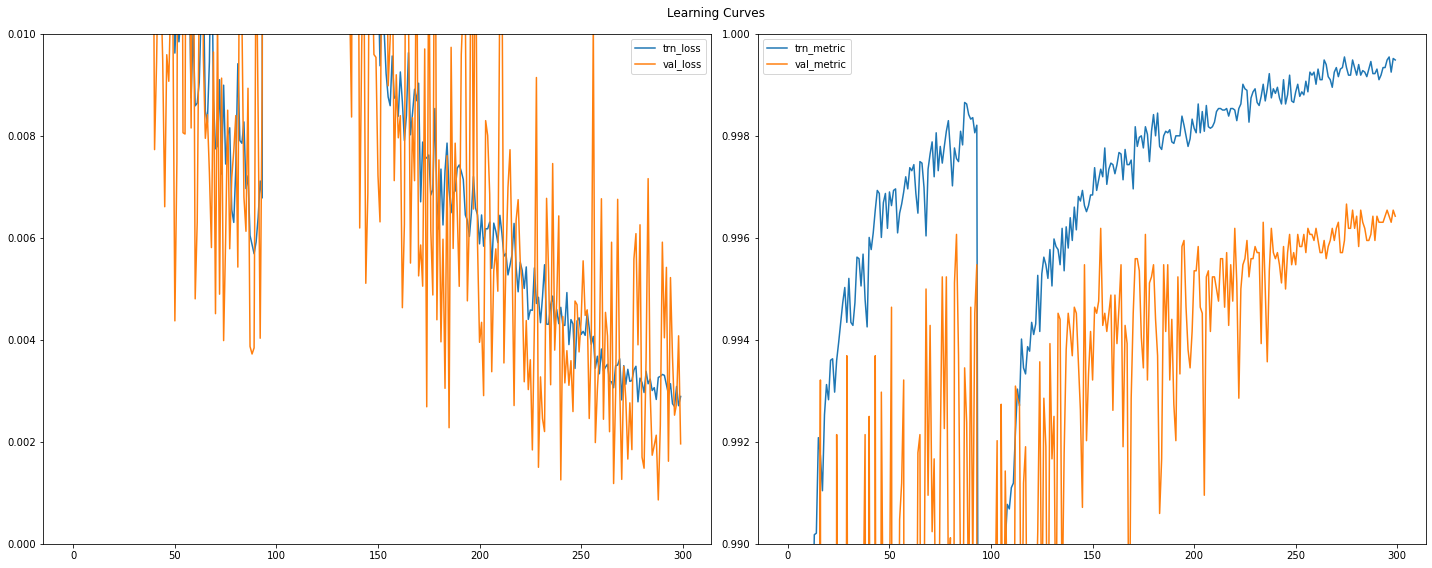

# Train Samples: 33600 | # Val Samples: 8400
# Parameters: 288170
EPOCH: 0 | LRs: {0.0040000000000000036}
(train) LOSS: 1.8185951 | METRIC: -0.434732
(valid) LOSS: 1.1415840 | METRIC: -0.351071
EPOCH: 1 | LRs: {0.00402926000147058}
(train) LOSS: 0.8130596 | METRIC: -0.792857
(valid) LOSS: 0.4876474 | METRIC: -0.809285
EPOCH: 2 | LRs: {0.004117004333062058}
(train) LOSS: 0.3472155 | METRIC: -0.923005
(valid) LOSS: 0.2019922 | METRIC: -0.950238
EPOCH: 3 | LRs: {0.004263126019804789}
(train) LOSS: 0.1952823 | METRIC: -0.953630
(valid) LOSS: 0.1356600 | METRIC: -0.928333
EPOCH: 4 | LRs: {0.004467446915000062}
(train) LOSS: 0.1278662 | METRIC: -0.970535
(valid) LOSS: 0.1296564 | METRIC: -0.952738
EPOCH: 5 | LRs: {0.004729717917410656}
(train) LOSS: 0.0974496 | METRIC: -0.977559
(valid) LOSS: 0.0858201 | METRIC: -0.982261
EPOCH: 6 | LRs: {0.0050496192749567015}
(train) LOSS: 0.0775039 | METRIC: -0.981994
(valid) LOSS: 0.0758986 | METRIC: -0.982976
EPOCH: 7 | LRs: {0.00542676097454689}
(train

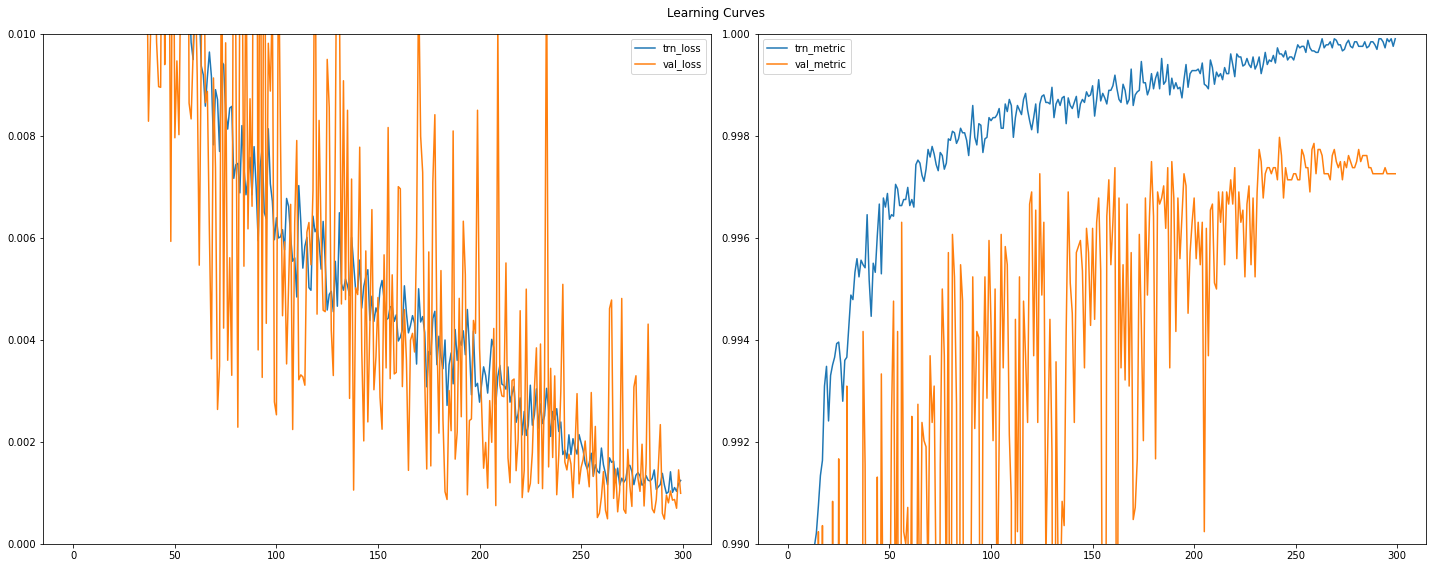

# Train Samples: 33600 | # Val Samples: 8400
# Parameters: 288170
EPOCH: 0 | LRs: {0.0040000000000000036}
(train) LOSS: 1.8932472 | METRIC: -0.424523
(valid) LOSS: 1.2950720 | METRIC: -0.411190
EPOCH: 1 | LRs: {0.00402926000147058}
(train) LOSS: 0.8819776 | METRIC: -0.777172
(valid) LOSS: 0.5894199 | METRIC: -0.885476
EPOCH: 2 | LRs: {0.004117004333062058}
(train) LOSS: 0.3945774 | METRIC: -0.907976
(valid) LOSS: 0.2815398 | METRIC: -0.959047
EPOCH: 3 | LRs: {0.004263126019804789}
(train) LOSS: 0.2046642 | METRIC: -0.954613
(valid) LOSS: 0.1334289 | METRIC: -0.974761
EPOCH: 4 | LRs: {0.004467446915000062}
(train) LOSS: 0.1334731 | METRIC: -0.969375
(valid) LOSS: 0.1104773 | METRIC: -0.959285
EPOCH: 5 | LRs: {0.004729717917410656}
(train) LOSS: 0.0994442 | METRIC: -0.977351
(valid) LOSS: 0.0834396 | METRIC: -0.976309
EPOCH: 6 | LRs: {0.0050496192749567015}
(train) LOSS: 0.0832125 | METRIC: -0.980089
(valid) LOSS: 0.0785209 | METRIC: -0.983928
EPOCH: 7 | LRs: {0.00542676097454689}
(train

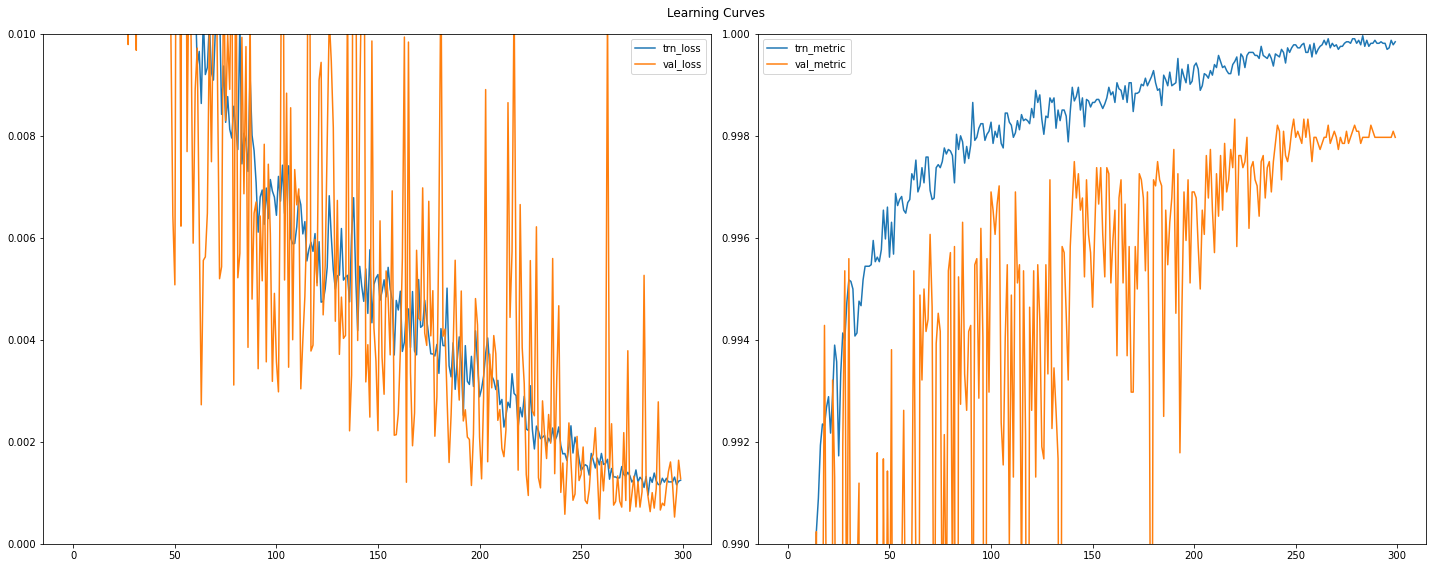

# Train Samples: 33600 | # Val Samples: 8400
# Parameters: 288170
EPOCH: 0 | LRs: {0.0040000000000000036}
(train) LOSS: 1.8487636 | METRIC: -0.412410
(valid) LOSS: 1.2002470 | METRIC: -0.530952
EPOCH: 1 | LRs: {0.00402926000147058}
(train) LOSS: 0.8263985 | METRIC: -0.796071
(valid) LOSS: 0.5149109 | METRIC: -0.925952
EPOCH: 2 | LRs: {0.004117004333062058}
(train) LOSS: 0.3441383 | METRIC: -0.924583
(valid) LOSS: 0.2529291 | METRIC: -0.912738
EPOCH: 3 | LRs: {0.004263126019804789}
(train) LOSS: 0.2022316 | METRIC: -0.951250
(valid) LOSS: 0.1959710 | METRIC: -0.875833
EPOCH: 4 | LRs: {0.004467446915000062}
(train) LOSS: 0.1352120 | METRIC: -0.967410
(valid) LOSS: 0.1039784 | METRIC: -0.962738
EPOCH: 5 | LRs: {0.004729717917410656}
(train) LOSS: 0.0998545 | METRIC: -0.976904
(valid) LOSS: 0.0762018 | METRIC: -0.979404
EPOCH: 6 | LRs: {0.0050496192749567015}
(train) LOSS: 0.0853431 | METRIC: -0.978869
(valid) LOSS: 0.0718883 | METRIC: -0.944404
EPOCH: 7 | LRs: {0.00542676097454689}
(train

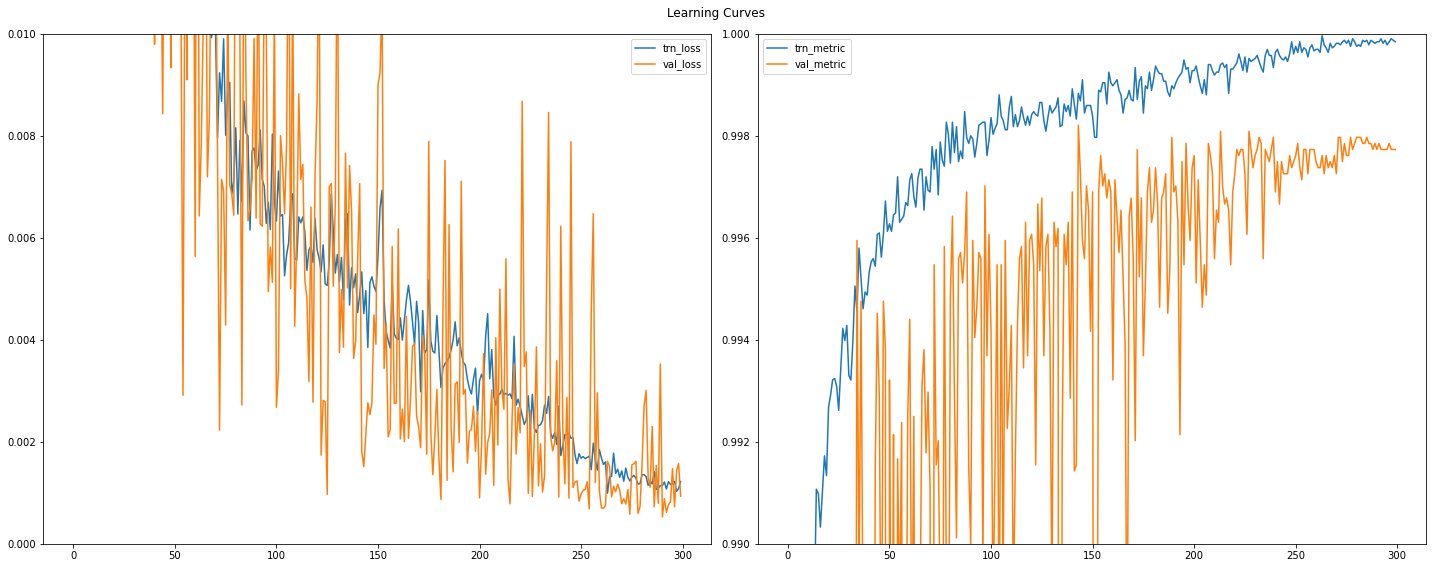

In [21]:
# fold1~4 모델들 학습 및 예측
for trn_idx, val_idx in folds[1:]:
    
    x_train, x_val, y_train, y_val = x_data[trn_idx], x_data[val_idx], y_data[trn_idx], y_data[val_idx]
    train_dataset = MNISTDataset(x_train, y_train, transforms=train_transforms)
    train_loader = torch.utils.data.DataLoader(train_dataset, config['batch_size'], shuffle=True, num_workers=config['num_workers'])
    val_dataset = MNISTDataset(x_val, y_val, transforms=None)
    val_loader = torch.utils.data.DataLoader(val_dataset, config['batch_size'], shuffle=False, num_workers=config['num_workers'])
    print(f'# Train Samples: {len(train_dataset)} | # Val Samples: {len(val_dataset)}')  
    
    model = Net(config['arch']).cuda()
    print(f'# Parameters: {sum(p.numel() for p in model.parameters())}')
    
    criterion = nn.CrossEntropyLoss()
    
    if config['optimizer'] == 'momentum':
        optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'], momentum=0.9)
    elif config['optimizer'] == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
        
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=config['epochs'])    
    # train
    t0 = time()

    # mixed precision
    scaler = torch.cuda.amp.GradScaler(enabled=config['amp']) 

    # validation metric 초기화
    best_val_metric = np.inf
    # learning curve
    learning_curve = pd.DataFrame(columns=['trn_loss', 'trn_metric', 'val_loss', 'val_metric'])

    # loop
    for epoch in range(config['epochs']):

        # 현재 learning rates 출력
        current_lrs = [x["lr"] for x in optimizer.param_groups]
        print(f'EPOCH: {epoch} | LRs: {set(current_lrs)}')

        # train
        model.train()
        train_loss = 0.0
        train_metric = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=config['amp']):
                logits = model(inputs) 
                loss = criterion(logits, targets)

            # mixed precision
            scaler.scale(loss).backward() 
            scaler.step(optimizer)  
            scaler.update() 

            optimizer.step()
            scheduler.step()

            train_loss += loss.item() * len(inputs) / len(train_dataset)
            train_metric -= (logits.detach().cpu().numpy().argmax(axis=1)==targets.detach().cpu().numpy()).mean() * len(inputs) / len(train_dataset)

        str_train_loss = str(train_loss)[:9]
        str_train_metric = str(train_metric)[:9]
        print(f'(train) LOSS: {str_train_loss} | METRIC: {str_train_metric}')

        # validate
        model.eval()
        val_loss = 0.0
        val_metric = 0.0
        val_preds = []
        val_targets = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.cuda(), targets.cuda()
                logits = model(inputs) 
                val_preds += logits.cpu().tolist()
                val_targets += targets.cpu().tolist()
                val_loss += loss.item() * len(inputs) / len(val_dataset)

        val_preds, val_targets = np.array(val_preds), np.array(val_targets)
        val_metric = -(val_preds.argmax(axis=1)==val_targets).mean() # negative accuracy
        str_val_metric = str(val_metric)[:9]
        str_val_loss = str(val_loss)[:9]
        print(f'(valid) LOSS: {str_val_loss} | METRIC: {str_val_metric}')

        # learning curve 업데이트
        learning_curve.loc[epoch] = train_loss, train_metric, val_loss, val_metric


        if val_metric <= best_val_metric:
            # val metric이 개선됐으면 info 저장
            best_info = {
                'epoch': epoch,
                'model': deepcopy(model.state_dict()),
                'amp_scaler': deepcopy(scaler.state_dict()),
                'optimizer': deepcopy(optimizer.state_dict()),
                'scheduler': deepcopy(scheduler.state_dict()),
                'learning_rates': current_lrs,
                'train_loss': train_loss,
                'train_metric': train_metric,
                'val_loss': val_loss,
                'val_metric': val_metric,
                'val_preds': val_preds,
                'config': config
            }
            best_val_metric = val_metric

    runtime = int(time()-t0)
    print(f'Best Val Score: {best_val_metric}')
    print(f'Runtime: {runtime}')

    # learning curve 그리기
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    fig.suptitle('Learning Curves')
    axes[0].plot(learning_curve['trn_loss'], label='trn_loss')
    axes[0].plot(learning_curve['val_loss'], label='val_loss')
    axes[0].set_ylim(0.0, 0.01)
    axes[0].legend()
    axes[1].plot(-learning_curve['trn_metric'], label='trn_metric')
    axes[1].plot(-learning_curve['val_metric'], label='val_metric')
    axes[1].set_ylim(0.99, 1.0)
    axes[1].legend()
    plt.tight_layout()
    plt.show()
    
    # oof, test 예측
    model.load_state_dict(best_info['model'])
    tmp_test_preds = []
    tmp_val_preds = []
    with torch.no_grad():
        for inputs in test_loader:
            tmp_test_preds.append(model(inputs.cuda()).cpu().numpy())
        for inputs, targets in val_loader:
            tmp_val_preds.append(model(inputs.cuda()).cpu().numpy().argmax(axis=1))
    oof_preds[val_idx] = np.concatenate(tmp_val_preds)
    test_preds += np.concatenate(tmp_test_preds)/len(folds)

In [22]:
print('OOF ACC:', (oof_preds==y_data).mean())

OOF ACC: 0.9978809523809524


# 최종 결과

* OOF: 0.99788
* Public LB: 0.99666
* Private LB: 0.99801

# 제출

In [23]:
submission = pd.read_csv('data/sample_submission.csv')
submission['Category'] = test_preds.argmax(axis=1)
submission.to_csv('submission.csv', index=False)

In [24]:
submission

,Id,Category
0,57808,8
1,4960,0
2,35755,5
3,15543,3
4,48968,8
...,...,...
17995,53718,8
17996,78,8
17997,33373,3
17998,36134,4
